Use restnet 34 for 3-4 sample and then train and compare it to effiecientnet for images training speed accuracy, observation should be rest net should be faster to train,efficient more accurate and small in size

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import numpy as np

# --- 1. Configuration ---
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 4 # Using 4 epochs for a quick but effective comparison

print(f"Running on device: {DEVICE}")

# --- 2. Data Loading & Preprocessing ---
# Normalization values for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- 3. Model Definition ---
def get_model(model_name: str, num_classes: int = 10):
    """
    Loads a pretrained model and adapts its final layer for CIFAR-10.
    """
    if model_name.lower() == 'resnet34':
        model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
        # Modify the final fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name.lower() == 'efficientnet_b0':
        model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
        # Modify the final classifier layer
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, num_classes),
        )
    else:
        raise ValueError("Unsupported model name. Choose 'resnet34' or 'efficientnet_b0'.")

    return model.to(DEVICE)

# --- 4. Training and Evaluation Loop ---
def train_and_evaluate(model_name: str):
    """
    A complete function to initialize, train, and evaluate a model.
    """
    print("-" * 50)
    print(f"🚀 Starting Training for: {model_name}")

    # Initialize model, loss, and optimizer
    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- Training Time ---
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/len(progress_bar))

    end_time = time.time()
    training_time = end_time - start_time

    # --- Accuracy Evaluation ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # --- Model Size (Parameters) ---
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # --- Print Results ---
    print(f"\n--- Results for {model_name} ---")
    print(f"Total Training Time: {training_time:.2f} seconds")
    print(f"Final Accuracy on Test Set: {accuracy:.2f}%")
    print(f"Number of Trainable Parameters: {num_params:,}")
    print("-" * 50)

    return {
        "model": model_name,
        "time": training_time,
        "accuracy": accuracy,
        "params": num_params
    }

# --- 5. Run Comparison ---
if __name__ == "__main__":
    resnet_results = train_and_evaluate("resnet34")
    efficientnet_results = train_and_evaluate("efficientnet_b0")

    # --- Final Comparison Table ---
    print("\n\n" + "="*60)
    print("📊 FINAL COMPARISON SUMMARY")
    print("="*60)
    print(f"{'Metric':<25} | {'ResNet-34':<15} | {'EfficientNet-B0':<15}")
    print("-"*60)
    print(f"{'Training Time (s)':<25} | {resnet_results['time']:<15.2f} | {efficientnet_results['time']:<15.2f}")
    print(f"{'Accuracy (%)':<25} | {resnet_results['accuracy']:<15.2f} | {efficientnet_results['accuracy']:<15.2f}")
    print(f"{'Parameters':<25} | {resnet_results['params']:,} | {efficientnet_results['params']:,}")
    print("="*60)

Running on device: cuda


100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]


--------------------------------------------------
🚀 Starting Training for: resnet34
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s]
Epoch 4/4: 100%|██████████| 391/391 [00:36<00:00, 10.58it/s, loss=0.324]



--- Results for resnet34 ---
Total Training Time: 147.18 seconds
Final Accuracy on Test Set: 81.68%
Number of Trainable Parameters: 21,289,802
--------------------------------------------------
--------------------------------------------------
🚀 Starting Training for: efficientnet_b0
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 167MB/s]
Epoch 4/4: 100%|██████████| 391/391 [00:25<00:00, 15.39it/s, loss=0.369]



--- Results for efficientnet_b0 ---
Total Training Time: 95.35 seconds
Final Accuracy on Test Set: 83.07%
Number of Trainable Parameters: 4,020,358
--------------------------------------------------


📊 FINAL COMPARISON SUMMARY
Metric                    | ResNet-34       | EfficientNet-B0
------------------------------------------------------------
Training Time (s)         | 147.18          | 95.35          
Accuracy (%)              | 81.68           | 83.07          
Parameters                | 21,289,802 | 4,020,358


Using device: cuda
Training on 200 images for 3 epochs.
Visualizing results on 4 test images.

--- Training U-Net + ResNet34 ---


Epoch 3/3: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, loss=0.395]


Training Time: 0m 12.12s

--- Training U-Net + EfficientNet-B0 ---


Epoch 3/3: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, loss=0.541]


Training Time: 0m 11.97s

Generating final masks...


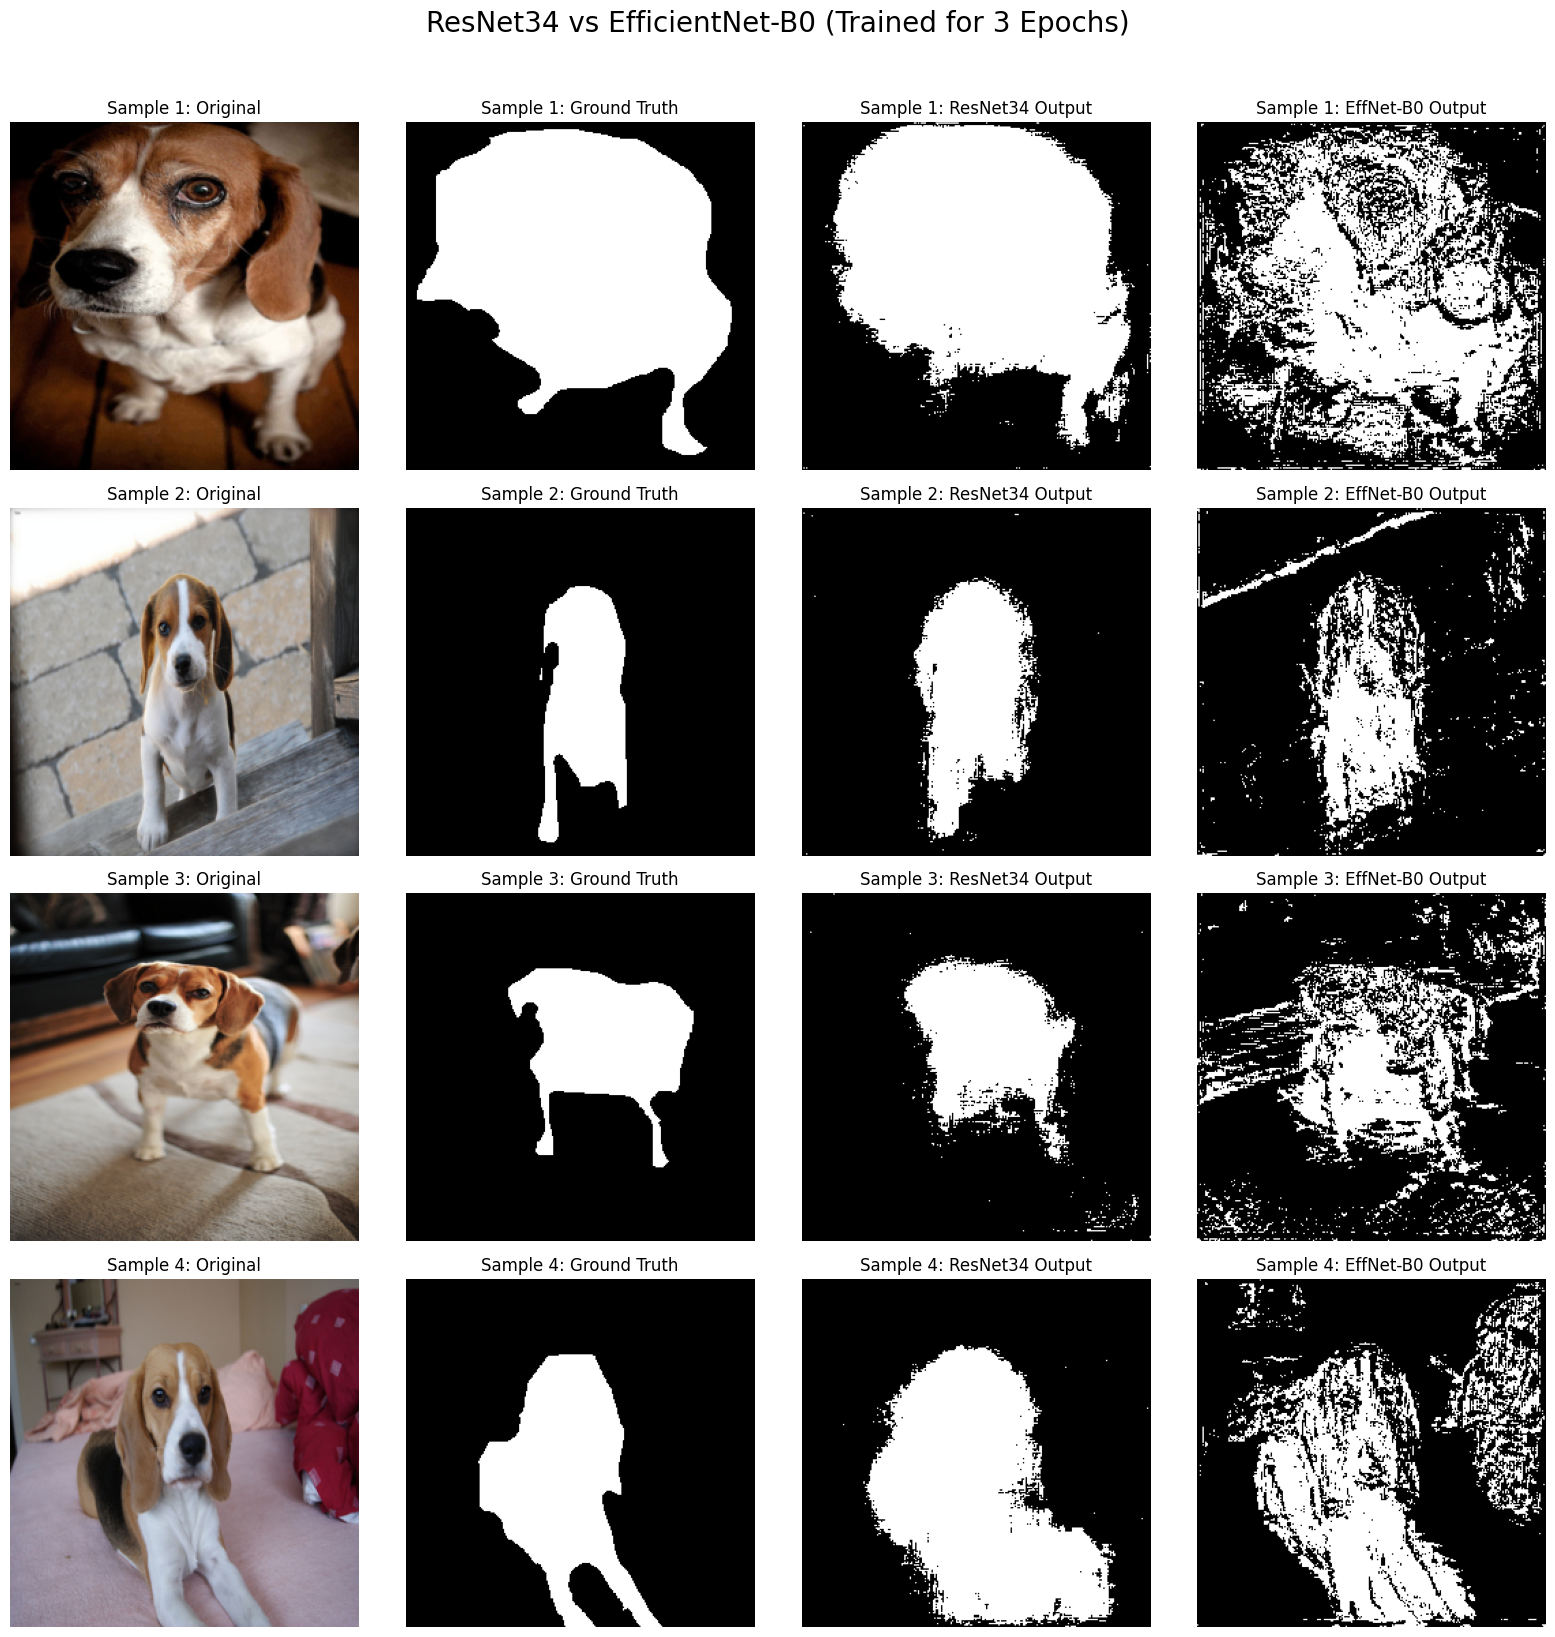


--- Final Parameter Count ---
U-Net + ResNet34 Parameters:     24.4 M
U-Net + EfficientNet-B0 Parameters: 6.3 M


In [ ]:
!pip install segmentation-models-pytorch timm -q
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Subset
import time
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from tqdm import tqdm
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# --- 1. Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Training parameters
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_TRAIN_SAMPLES = 200 # Use 200 images for a stable, quick training run
NUM_TEST_SAMPLES = 4

# --- 2. Data Preparation ---

# Define transforms
image_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor()
])

# Load the dataset
try:
    dataset = OxfordIIITPet(root="./data", split="trainval", download=True, target_types="segmentation")
except Exception as e:
    print(f"Could not download dataset: {e}")
    exit()

# Custom collate function to apply transforms
def collate_fn(batch):
    images, masks = [], []
    for img, mask in batch:
        images.append(image_transform(img))
        transformed_mask = mask_transform(mask)
        binary_mask = (transformed_mask == 1).float() # 1 = Pet
        masks.append(binary_mask)
    return torch.stack(images), torch.stack(masks)

# Create a training subset
train_subset_indices = range(NUM_TRAIN_SAMPLES)
train_subset = Subset(dataset, train_subset_indices)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

# Create a test subset (the 4 samples we'll visualize)
test_subset_indices = range(NUM_TRAIN_SAMPLES, NUM_TRAIN_SAMPLES + NUM_TEST_SAMPLES)
test_subset = Subset(dataset, test_subset_indices)
test_loader = DataLoader(test_subset, batch_size=NUM_TEST_SAMPLES, collate_fn=collate_fn)

print(f"Training on {NUM_TRAIN_SAMPLES} images for {NUM_EPOCHS} epochs.")
print(f"Visualizing results on {NUM_TEST_SAMPLES} test images.")

# --- 3. Model Definitions ---

# Model 1: U-Net with ResNet34
model_resnet34 = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(DEVICE)

# Model 2: U-Net with EfficientNet-B0
model_efficientnet_b0 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(DEVICE)

# --- 4. Training Function ---

def train_model(model, model_name):
    print(f"\n--- Training {model_name} ---")
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
        for images, masks in pbar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

    end_time = time.time()
    train_time = end_time - start_time
    print(f"Training Time: {train_time // 60:.0f}m {train_time % 60:.2f}s")
    return train_time

# --- 5. Run Training and Comparison ---

time_resnet34 = train_model(model_resnet34, "U-Net + ResNet34")
time_efficientnet_b0 = train_model(model_efficientnet_b0, "U-Net + EfficientNet-B0")

# --- 6. Get Visual Results ---

print("\nGenerating final masks...")
model_resnet34.eval()
model_efficientnet_b0.eval()

# Get the test batch
images, masks = next(iter(test_loader))
images = images.to(DEVICE)

with torch.no_grad():
    # Get ResNet34 outputs
    outputs_resnet34 = model_resnet34(images)
    masks_resnet34 = (torch.sigmoid(outputs_resnet34) > 0.5).float().cpu()

    # Get EfficientNet-B0 outputs
    outputs_efficientnet_b0 = model_efficientnet_b0(images)
    masks_efficientnet_b0 = (torch.sigmoid(outputs_efficientnet_b0) > 0.5).float().cpu()

# --- 7. Visualization ---

def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().cpu().permute(1, 2, 0).numpy()
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

fig, axes = plt.subplots(NUM_TEST_SAMPLES, 4, figsize=(16, NUM_TEST_SAMPLES * 4))
fig.suptitle("ResNet34 vs EfficientNet-B0 (Trained for 3 Epochs)", fontsize=20, y=1.02)

images_cpu = images.cpu() # Move images to CPU for plotting

for i in range(NUM_TEST_SAMPLES):
    axes[i, 0].imshow(denormalize(images_cpu[i]))
    axes[i, 0].set_title(f"Sample {i+1}: Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
    axes[i, 1].set_title(f"Sample {i+1}: Ground Truth")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(masks_resnet34[i].squeeze(), cmap='gray')
    axes[i, 2].set_title(f"Sample {i+1}: ResNet34 Output")
    axes[i, 2].axis('off')

    axes[i, 3].imshow(masks_efficientnet_b0[i].squeeze(), cmap='gray')
    axes[i, 3].set_title(f"Sample {i+1}: EffNet-B0 Output")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

# --- 8. Final Parameter Count ---
print("\n--- Final Parameter Count ---")
params_resnet34 = count_parameters(model_resnet34)
params_efficientnet_b0 = count_parameters(model_efficientnet_b0)
print(f"U-Net + ResNet34 Parameters:     {params_resnet34/1e6:.1f} M")
print(f"U-Net + EfficientNet-B0 Parameters: {params_efficientnet_b0/1e6:.1f} M")